# ATMS 523 Module 4 Homework
 - B. Engelsen 10/10/22

#### References

- THREDDS ERA5 Reanalysis (0.25 Degree Latitude-Longitude Grid)
    - ds633.0 | DOI: 10.5065/BH6N-5N20

- AWS ERA5 data Generated from Copernicus Climate Change Service
    - Amazon Resource Name (ARN):aws:s3:::era5-pds
    - URL: http://era5-pds.s3.amazonaws.com/

### A . Read in Packages

In [1]:
# import seaborn as sb
import xarray as xr
import numpy as np
from glob import glob as gg
import os
import urllib.request # module for downloading data from URLs
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs 
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
import datetime as dt
import chardet
from pandas.tseries.offsets import MonthEnd
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from netCDF4 import Dataset
import h5py
import eofs
from eofs.xarray import Eof
from eofs.examples import example_data_path

### B. Set up local cluster on laptop

In [3]:
# client.close()

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54122,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.39 GiB
Comm: tcp://127.0.0.1:54166,Total threads: 2
Dashboard: http://127.0.0.1:54167/status,Memory: 3.85 GiB
Nanny: tcp://127.0.0.1:54128,


### Question 1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and precipitation anomalies from Jan 1979-Dec 2021 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The land sea mask is available here: https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc

### C. Read in data from Thredds data server. Doi in markdown above

In [5]:
lat_min = 65.0
lat_max = -65.0

lon_min = 120.0
lon_max = 60.0

In [1]:
# Mean convective precipitation rate	kg m-2 s-1
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/'
base_url2 = '/e5.moda.fc.sfc.meanflux.235_030_mcpr.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)

ds_cpr = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
    sel(latitude=slice(lat_min,lat_max,4),longitude=slice(lon_min,360.0-lon_max,4))

#Mean large-scale precipitation rate	kg m-2 s-1
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/'
base_url2 = '/e5.moda.fc.sfc.meanflux.235_029_mlspr.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)


ds_lspr = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
    sel(latitude=slice(lat_min,lat_max,4),longitude=slice(lon_min,360.0-lon_max,4))

#Combine Large Scale and Convective Precip
da_precip = ds_lspr['MLSPR'] + ds_cpr['MCPR']
ds_precip = da_precip.to_dataset(name="precip")

#Sea Surface Temperatures   K
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')
# Jan 1979-Dec 2021

file_list = []

for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    date_str = dt.strftime('%Y%m%d%H')
    date_str_2 = (dt + pd.DateOffset(month=12)).strftime('%Y%m%d%H')        # build complete file name
    single_file=(base_url+year+base_url2+date_str+'_'+date_str_2+base_url3)
    file_list.append(single_file)

ds_sst = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
    sel(latitude=slice(lat_min,lat_max,4),longitude=slice(lon_min,360.0-lon_max,4))

In [ ]:
# ds_sst

In [ ]:
# ds_precip

In [ ]:
ds_total = xr.merge([ds_precip, ds_sst])

### Question 2) From the dataset shown in 1, deseasonalize (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies. Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: 6.3. Preprocessing data — scikit-learn 1.1.2 documentation

#### Deseasonlize

In [ ]:
ds_clim = ds_total.groupby('time.month').mean(dim='time')
ds_anom = (ds_total.groupby('time.month') - ds_clim)

In [25]:
# ds_anom

#### Detrend

In [ ]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [ ]:
ds_anom['SSTK'] = detrend_dim(ds_anom['SSTK'], 'time', deg=1)
ds_anom['precip'] = detrend_dim(ds_anom['precip'], 'time', deg=1)

#### Standardize

In [ ]:
climatology_mean_precip = ds_anom['precip'].groupby("time.month").mean("time")
climatology_std_precip = ds_anom['precip'].groupby("time.month").std("time")
stand_anomalies_preip = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_anom.groupby("time.month"),
    climatology_mean_precip,
    climatology_std_precip,
    dask="parallelized"
)

climatology_mean_sst = ds_anom['SSTK'].groupby("time.month").mean("time")
climatology_std_sst = ds_anom['SSTK'].groupby("time.month").std("time")
stand_anomalies_sst = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_anom.groupby("time.month"),
    climatology_mean_sst,
    climatology_std_sst,
    dask="parallelized"
)

In [8]:
# final_sst = stand_anomalies_sst.compute()
# final_precip = stand_anomalies_preip.compute()

final_sst = xr.open_dataset('final_sst.nc')
final_precip = xr.open_dataset('final_precip.nc')

In [10]:
final_sst = final_sst.drop_vars('month')
final_precip = final_precip.drop_vars('month')

In [ ]:
#output sliced data
# final_sst.to_netcdf('final_sst.nc')
# final_precip.to_netcdf('final_precip.nc')

In [38]:
# final_sst['precip'].sel(time='1997-12-01').plot()

### Question 3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

In [11]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(final_sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(final_sst['SSTK'], weights=wgts)

In [12]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# EOFs - What is the pattern of sst variablity that explains the most variance within the observational record
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=10, pcscaling=1)

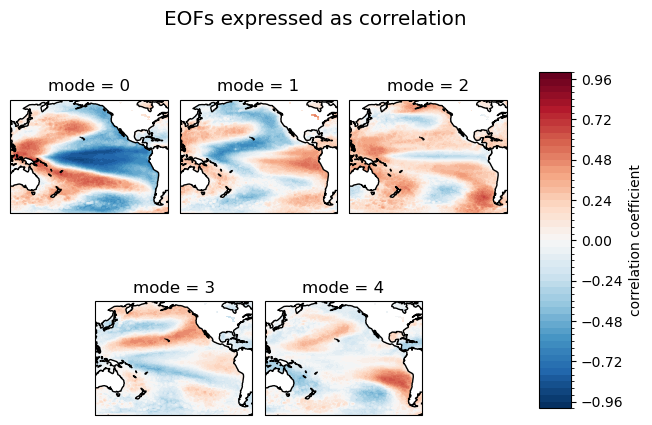

In [75]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
fig = plt.figure()
st = fig.suptitle("EOFs expressed as correlation", fontsize="x-large")
clevs = np.linspace(-1, 1, 51)
ax0 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax0, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax0.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

ax1 = plt.subplot2grid((2,6), loc=(0,2), colspan=2, projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[1].plot.contourf(ax=ax1, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

ax2 = plt.subplot2grid((2,6), loc=(0,4), colspan=2, projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[2].plot.contourf(ax=ax2, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

ax3 = plt.subplot2grid((2,6), loc=(1,1), colspan=2, projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[3].plot.contourf(ax=ax3, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

ax4 = plt.subplot2grid((2,6), loc=(1,3), colspan=2, projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[4].plot.contourf(ax=ax4, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(fill, cax=cbar_ax)
cbar.set_label('correlation coefficient')


### Question 4) Plot the percent of variance explained by the first 10 EOFs.

In [14]:
varfrac = solver.varianceFraction()

(4.0700706448741514e-34, 0.18905759110809686)

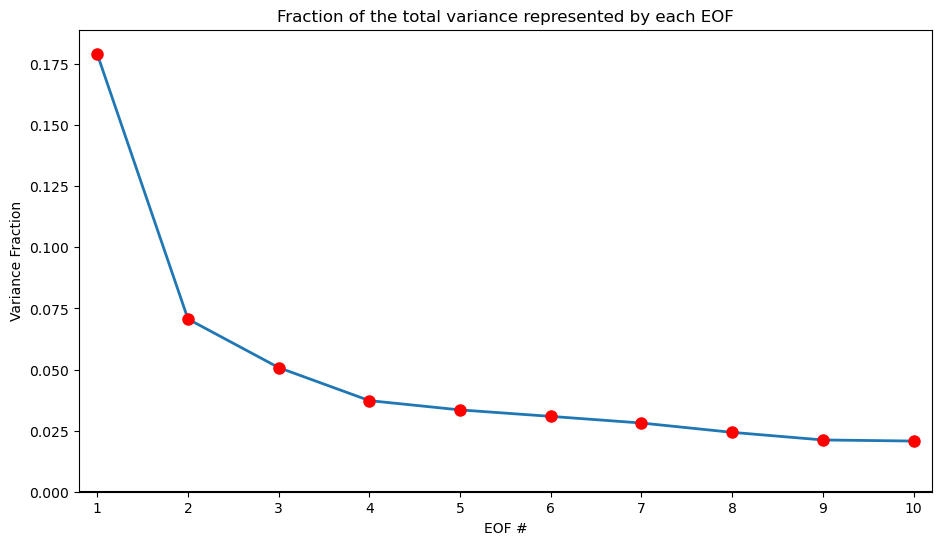

In [33]:
# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(0.8, 10.2)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

### Question 5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series and the "observed" SST time series.

In [61]:
reconstruction = solver.reconstructedField(5)

In [62]:
pears_cc = xr.corr(reconstruction, final_sst['SSTK'], dim='time')

c:\ProgramData\Anaconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\Anaconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Correlation between Oberved SSTs and Reconstructed SST field from EOFs 1-5')

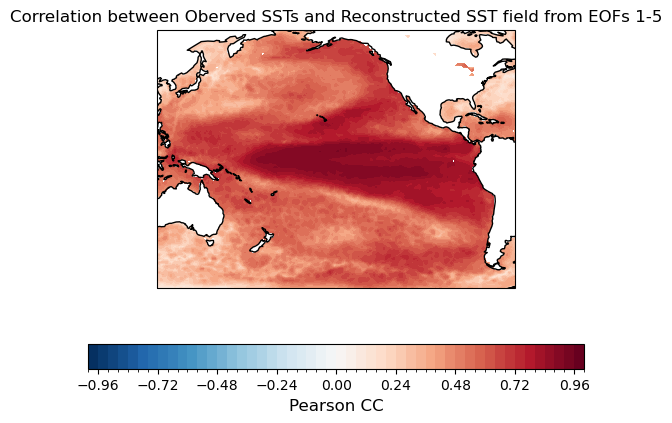

In [74]:
# Plot the reconstructed and observed SSTs in the Pacific domain.
clevs = np.linspace(-1, 1, 51)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = pears_cc.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Pearson CC', fontsize=12)
plt.title('Correlation between Oberved SSTs and Reconstructed SST field from EOFs 1-5')

### Question 6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot). See anything interesting?

In [67]:
reconstruction1 = solver.reconstructedField(1)
pears2_cc = xr.corr(reconstruction1, final_precip['precip'], dim='time')

c:\ProgramData\Anaconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\Anaconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Correlation between Oberved Precipitation and EOF1')

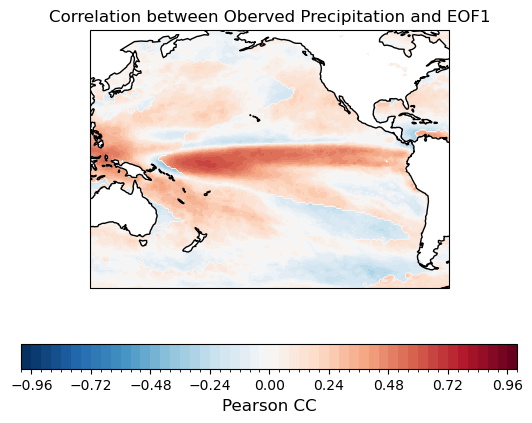

In [72]:
# Plot the EOF1 and observed Precip in the Pacific domain.
clevs = np.linspace(-1, 1, 51)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = pears2_cc.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Pearson CC', fontsize=12)
plt.title('Correlation between Oberved Precipitation and EOF1')

### Question 7) SST anoms-> Module 2 Precip anoms-> Module 2

In [39]:
pears3_cc = xr.corr(reconstruction, final_precip['precip'], dim='time')

c:\ProgramData\Anaconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\Anaconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Correlation between Oberved Precip and Reconstructed SST field from EOFs 1-5')

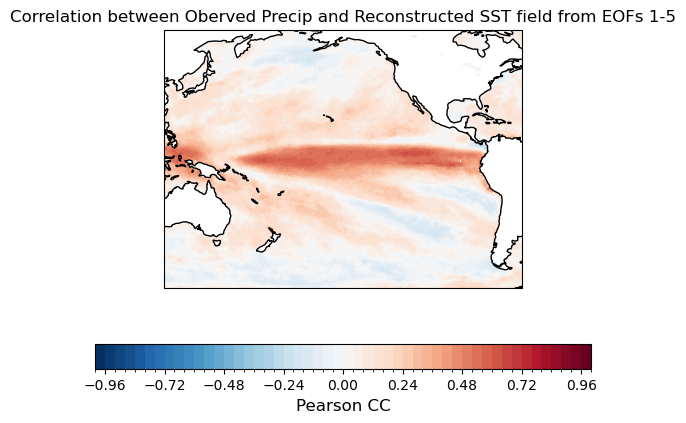

In [73]:
# Plot the reconstructed and observed Precip in the Pacific domain.
clevs = np.linspace(-1, 1, 51)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = pears3_cc.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Pearson CC', fontsize=12)
plt.title('Correlation between Oberved Precip and Reconstructed SST field from EOFs 1-5')

Text(0.5, 1.0, 'PC1 Time Series')

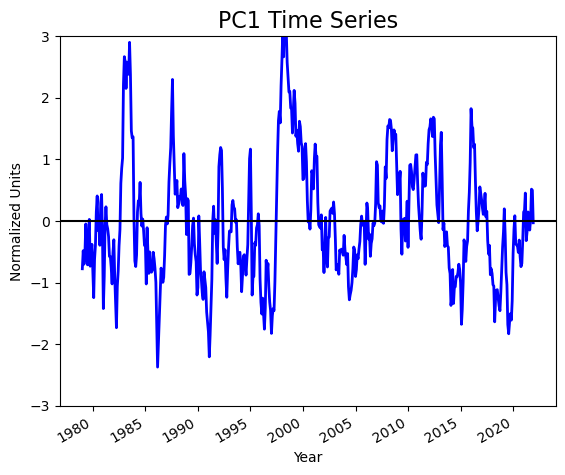

In [30]:
# Plot the leading PC time series.
plt.figure()
pc1[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)


Text(0.5, 1.0, 'EOF2 expressed as correlation')

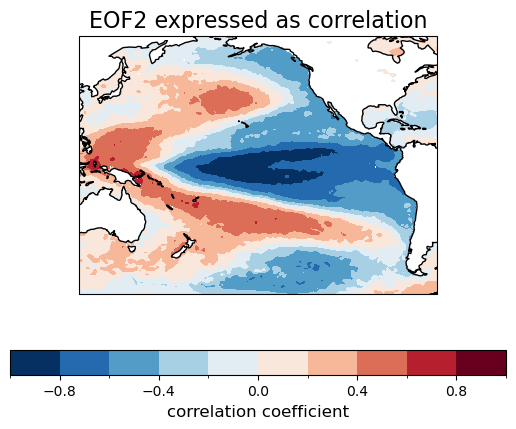

In [65]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF2 expressed as correlation', fontsize=16)


In [ ]:
#plot 1981-2010 anomaly of precip centered around Rockton, IL

#plotting setup
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'color': 'black'}

# set extent and plot data points to zoom in
ax.set_extent([(360.-lon_rock)-20,(360.-lon_rock)+20, lat_rock +20,lat_rock-20], crs=ccrs.PlateCarree())

image = plt.contourf(anomaly_wind.longitude,anomaly_wind.latitude,anomaly_wind, 100, 
                    cmap='bwr', transform=ccrs.PlateCarree())

image2 = plt.scatter(360.-lon_rock,lat_rock, transform = ccrs.PlateCarree(), color='r', marker='x', s=50,label="Rockton, IL")

#plot attributes
plt.title('250 mb Wind Speed Anomaly from the 1981-2010 AMJ mean \n Precipitation Events Centered Around Rockton, IL')
cb = plt.colorbar(image,fraction=0.046, pad=0.04)
cb.set_label('Wind Speed (m/s)')
# plt.legend(bbox_to_anchor=(.95, 0.1), loc=1)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)


### Plot anomaly_q

### Close client to free up RAM

In [ ]:
client.close()